## Problem 1 

Find, by the use of Figure 1, the direct kinematic transformations, T0
4 for the
robot stylus, and T0
5 for the robot camera, as function of all joint angles.

In [21]:
# Import libraries

import sympy as sp
from sympy import init_printing
from sympy import pprint
import numpy as np
import math

theta1 = sp.symbols('theta1')
theta2 = sp.symbols('theta2')
theta3 = sp.symbols('theta3')
theta4 = sp.symbols('theta4')


# DH Transformation Matrix

def dh_matrix(theta, d, a, alpha):
    """
    Standard DH:
    A = Rot_z(theta) * Trans_z(d) * Trans_x(a) * Rot_x(alpha)
    """
    ct = sp.cos(theta)
    st = sp.sin(theta)
    ca = sp.cos(alpha)
    sa = sp.sin(alpha)

    return sp.Matrix([
        [ct, -st * ca,  st * sa, a * ct],
        [st,  ct * ca, -ct * sa, a * st],
        [0,      sa,      ca,     d   ],
        [0,      0,       0,      1   ]
    ])

In [22]:

# Calculate A1 to A 4

a1 = dh_matrix(theta1, 50, 0, sp.pi/2)
a2 = dh_matrix(theta2 , 0, 93, 0)
a3 = dh_matrix(theta3, 0, 93, 0)
a4 = dh_matrix(theta4, 0, 50, 0)
print (f'A1: {a1}')
print (f'A2: {a2}')
print (f'A3: {a3}')
print (f'A4: {a4}')

a5 = sp.Matrix([[1, 0, 0, -15], [0, 1, 0, 45], [0, 0, 1, 0], [0, 0, 0, 1]])
init_printing(a4)

A1: Matrix([[cos(theta1), 0, sin(theta1), 0], [sin(theta1), 0, -cos(theta1), 0], [0, 1, 0, 50], [0, 0, 0, 1]])
A2: Matrix([[cos(theta2), -sin(theta2), 0, 93*cos(theta2)], [sin(theta2), cos(theta2), 0, 93*sin(theta2)], [0, 0, 1, 0], [0, 0, 0, 1]])
A3: Matrix([[cos(theta3), -sin(theta3), 0, 93*cos(theta3)], [sin(theta3), cos(theta3), 0, 93*sin(theta3)], [0, 0, 1, 0], [0, 0, 0, 1]])
A4: Matrix([[cos(theta4), -sin(theta4), 0, 50*cos(theta4)], [sin(theta4), cos(theta4), 0, 50*sin(theta4)], [0, 0, 1, 0], [0, 0, 0, 1]])


In [23]:
# Multiply to get T0_4
t0_4 = a1 * a2 * a3 * a4 
t0_5 = t0_4 * a5
print(f'T0_4: {t0_4}')
print(f'T0_5: {t0_5}')

T04_simpl = sp.simplify(sp.trigsimp(t0_4, method='fu'))
T05_simpl = sp.simplify(sp.trigsimp(t0_5, method='fu'))
# sp.pprint(T04_simpl[:,3])

T0_4: Matrix([[(-sin(theta2)*sin(theta3)*cos(theta1) + cos(theta1)*cos(theta2)*cos(theta3))*cos(theta4) + (-sin(theta2)*cos(theta1)*cos(theta3) - sin(theta3)*cos(theta1)*cos(theta2))*sin(theta4), -(-sin(theta2)*sin(theta3)*cos(theta1) + cos(theta1)*cos(theta2)*cos(theta3))*sin(theta4) + (-sin(theta2)*cos(theta1)*cos(theta3) - sin(theta3)*cos(theta1)*cos(theta2))*cos(theta4), sin(theta1), 50*(-sin(theta2)*sin(theta3)*cos(theta1) + cos(theta1)*cos(theta2)*cos(theta3))*cos(theta4) + 50*(-sin(theta2)*cos(theta1)*cos(theta3) - sin(theta3)*cos(theta1)*cos(theta2))*sin(theta4) - 93*sin(theta2)*sin(theta3)*cos(theta1) + 93*cos(theta1)*cos(theta2)*cos(theta3) + 93*cos(theta1)*cos(theta2)], [(-sin(theta1)*sin(theta2)*sin(theta3) + sin(theta1)*cos(theta2)*cos(theta3))*cos(theta4) + (-sin(theta1)*sin(theta2)*cos(theta3) - sin(theta1)*sin(theta3)*cos(theta2))*sin(theta4), -(-sin(theta1)*sin(theta2)*sin(theta3) + sin(theta1)*cos(theta2)*cos(theta3))*sin(theta4) + (-sin(theta1)*sin(theta2)*cos(theta3

## Problem 2
Determine the inverse kinematic transformation

In [24]:
# x4 = T04_simpl[:3,0]
# o4 = T04_simpl[:3,3]

x4 = t0_4[:3,0]
o4 = t0_4[:3,3]

o4x = o4[0,0]
o4y = o4[1,0]
o4z = o4[2,0]

In [25]:
L1 = 50.0   # base offset  (d1)
L2 = 93.0   # link 2 length (a2)
L3 = 93.0   # link 3 length (a3)
L4 = 50.0   # link 4 length (a4)

def inverse_kinematics(o4x, o4y, o4z, x4z_des=0.0, tol=1e-9):
    """
    IK for your DH chain:
        A1 = DH(q1, 50, 0, pi/2)
        A2 = DH(q2, 0, 93, 0)
        A3 = DH(q3, 0, 93, 0)
        A4 = DH(q4, 0, 50, 0)
    Find all (q1,q2,q3,q4) such that:
        position = (o4x, o4y, o4z)
        and (x4^0)_z = x4z_des
    Returns a list of numpy arrays, possibly empty.
    """

    # 1) base joint from xy
    q1 = math.atan2(o4y, o4x)
    rho = math.hypot(o4x, o4y)   # horizontal distance

    # 2) orientation scalar: (x4^0)_z = sin(S)
    x4z_des = float(np.clip(x4z_des, -1.0, 1.0))
    S0 = math.asin(x4z_des)
    # two possible totals for S = q2+q3+q4
    S_candidates = (S0, math.pi - S0)

    sols = []

    for S in S_candidates:
        # 3) subtract the last link (50 mm) that is rotated by S
        # original point, seen from joint-2 plane:
        #   rho  = 93 cos q2 + 93 cos(q2+q3) + 50 cos S
        #   z    = 50 + 93 sin q2 + 93 sin(q2+q3) + 50 sin S
        # so after subtraction we get the pure 2R part:
        rho_p = rho - L4 * math.cos(S)
        z_p   = (o4z - L1) - L4 * math.sin(S)

        # 4) planar 2R IK for links L2, L3
        num = rho_p**2 + z_p**2 - L2**2 - L3**2
        den = 2.0 * L2 * L3
        if abs(den) < tol:
            continue  # degenerate, shouldn't happen here

        c3 = num / den

        # reachability with tolerance
        if c3 < -1.0 - 1e-6 or c3 > 1.0 + 1e-6:
            # this S doesn't make the point reachable
            continue

        c3 = max(min(c3, 1.0), -1.0)     # clamp
        s3_abs = math.sqrt(max(0.0, 1.0 - c3**2))

        # two elbow configurations
        for s3 in (s3_abs, -s3_abs):
            q3 = math.atan2(s3, c3)

            # shoulder (standard 2R formula)
            q2 = math.atan2(z_p, rho_p) - math.atan2(
                L3 * math.sin(q3),
                L2 + L3 * math.cos(q3)
            )

            # 5) recover q4 from S = q2 + q3 + q4
            q4 = S - (q2 + q3)

            sols.append(np.array([q1, q2, q3, q4], dtype=float))

    return sols



## Problem 3

In [26]:
R = 32 # radius
pc = np.array([150, 0, 120]) # mm 

configs = []

for j in range(37):
    phi = 2*np.pi*j/36

    o4x = pc[0] + 0
    o4y = pc[1] + R*np.cos(phi)
    o4z = pc[2] + R*np.sin(phi)

    configs.append(inverse_kinematics(o4x, o4y, o4z))

# for i in configs:
#     print (i)



## Problem 4

In [27]:
def compute_geometric_jacobian(T_list, frame_index=4):
    o_n = np.array(T_list[frame_index][:3, 3], dtype=float)
    J   = np.zeros((6, 4), dtype=float)

    for i in range(1, 5):  # joints 1..4
        o_im1 = np.array(T_list[i-1][:3, 3], dtype=float)   # origin of frame {i-1}
        z_im1 = np.array(T_list[i-1][:3, 2], dtype=float)   # z-axis of frame {i-1} in base
# 
        J[:3, i-1] = np.cross(z_im1, (o_n - o_im1))         # linear
        J[3:, i-1] = z_im1                                  # angular
    return J

In [28]:
def forward_kin_numeric(q):

    # Converts matrices sympy in numpy 
    subs = {theta1:q[0], theta2:q[1], theta3:q[2], theta4:q[3]}
    A1n = np.array(a1.evalf(subs=subs)).astype(np.float64)
    A2n = np.array(a2.evalf(subs=subs)).astype(np.float64)
    A3n = np.array(a3.evalf(subs=subs)).astype(np.float64)
    A4n = np.array(a4.evalf(subs=subs)).astype(np.float64)
    A5n = np.array(a5.evalf(subs=subs)).astype(np.float64)

    T0 = np.eye(4)
    T1 = A1n
    T2 = T1 @ A2n
    T3 = T2 @ A3n
    T4 = T3 @ A4n
    T5 = T4 @ A5n
    return [T0, T1, T2, T3, T4, T5]

# Same process as Problem 3 with only 4 different phi values + Jacobian
phis = [0, np.pi/2, np.pi, 3*np.pi/2]
R = 32
pc = np.array([150, 0, 120])

for phi in phis:
    o4x = pc[0]
    o4y = pc[1] + R*np.cos(phi)
    o4z = pc[2] + R*np.sin(phi)
    q = np.array(inverse_kinematics(o4x, o4y, o4z), dtype=float)[0]

    T_list = forward_kin_numeric(q)
    J_stylus = compute_geometric_jacobian(T_list, frame_index=4)
    J_camera = compute_geometric_jacobian(T_list, frame_index=5)

    # print(f"\nφ = {phi:.2f} rad ")
    # print("q =", np.round(q, 4))
    print("Jacobian Stylus:\n", np.round(J_stylus, 3))
    # print("Jacobian Camera:\n", np.round(J_camera, 3))

Jacobian Stylus:
 [[-32.    -68.459 -90.056  -0.   ]
 [150.    -14.605 -19.212   0.   ]
 [  0.    153.375  63.035  50.   ]
 [  0.      0.209   0.209   0.209]
 [  0.     -0.978  -0.978  -0.978]
 [  1.      0.      0.      0.   ]]
Jacobian Stylus:
 [[  -0.    -102.     -92.7     -0.   ]
 [ 150.      -0.      -0.       0.   ]
 [   0.     150.      57.466   50.   ]
 [   0.       0.       0.       0.   ]
 [   0.      -1.      -1.      -1.   ]
 [   1.       0.       0.       0.   ]]
Jacobian Stylus:
 [[ 32.    -68.459 -90.056   0.   ]
 [150.     14.605  19.212   0.   ]
 [ -0.    153.375  63.035  50.   ]
 [  0.     -0.209  -0.209  -0.209]
 [  0.     -0.978  -0.978  -0.978]
 [  1.      0.      0.      0.   ]]
Jacobian Stylus:
 [[  0.    -38.    -90.117   0.   ]
 [150.      0.      0.      0.   ]
 [ -0.    150.     72.975  50.   ]
 [  0.     -0.     -0.     -0.   ]
 [  0.     -1.     -1.     -1.   ]
 [  1.      0.      0.      0.   ]]


## Problem 5
Compute the joint velocities 


In [29]:
phi = np.pi/2
stylus_tip_velocity = [0, -3, 0]

def compute_joint_velocities(q, desired_velocity, phi):

    o4x = pc[0] + 0
    o4y = pc[1] + R*np.cos(phi)
    o4z = pc[2] + R*np.sin(phi)

    q = np.array(inverse_kinematics(o4x, o4y, o4z), dtype=float)[0]

    T_list = forward_kin_numeric(q)
    J = compute_geometric_jacobian(T_list, frame_index=4)
    J_v = J[:3, :]
    J_w = J[3:, :]
    
    # Find x_4
    R04 = T_list[4][:3,:3]
    x4 = R04[:,0]

    ez = np.array([0., 0., 1.])
    row4 = (np.cross(ez, x4) @ J_w).reshape(1, -1)

    A = np.vstack([J_v, row4])
    b = np.hstack([desired_velocity, 0.0]) 

    qdot = np.linalg.solve(A, b) #q_dot = (A^-1) * b

    return qdot

qdot = compute_joint_velocities(q, stylus_tip_velocity, phi)
print(qdot)

[-2.00000000e-02 -3.43882611e-20  4.60586672e-19 -4.26198411e-19]



## Problem 8


In [30]:
# Force 1 N

R = 32.0
pc = np.array([150.0, 0.0, 120.0])  # mm

def circle_point(phi):
    o4x = pc[0]
    o4y = pc[1] + R*np.cos(phi)
    o4z = pc[2] + R*np.sin(phi)
    return o4x, o4y, o4z

def calculate_joint_torques():
    f = np.array([0, 0, -1])
    taus = []
    phis = np.linspace(0, 2*np.pi, 361)

    for phi in phis:
        o4x, o4y, o4z = circle_point(phi)
        solution = inverse_kinematics(o4x, o4y, o4z)
        q = np.array(solution[0], float)
        T_list = forward_kin_numeric(q)
        J = compute_geometric_jacobian(T_list, frame_index=4)
        J_v = J[:3, :] * 1e-3
        tau = J_v.T @ f
        taus.append(tau)
    return np.array(phis), np.array(taus)


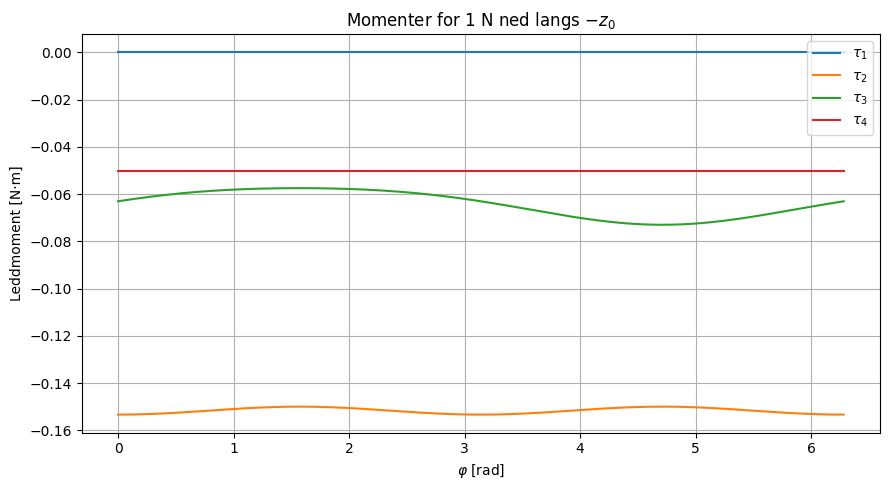

In [ ]:
import matplotlib.pyplot as plt

phis, taus = calculate_joint_torques()

plt.figure(figsize=(9,5))
labels = [r'$\tau_1$', r'$\tau_2$', r'$\tau_3$', r'$\tau_4$']
for i in range(4):
    plt.plot(phis, taus[:, i], label=labels[i])
plt.xlabel(r'$\varphi$ [rad]')
plt.ylabel('Leddmoment [N·m]')
plt.title('Momenter for 1 N ned langs $-z_0$')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()